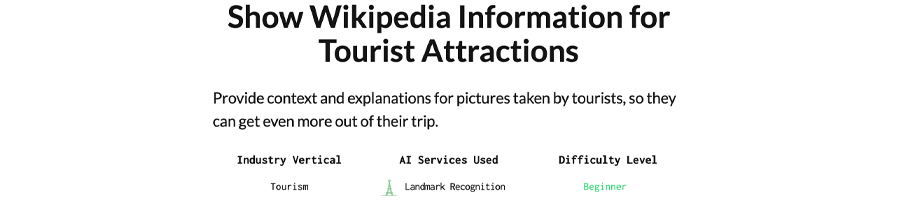

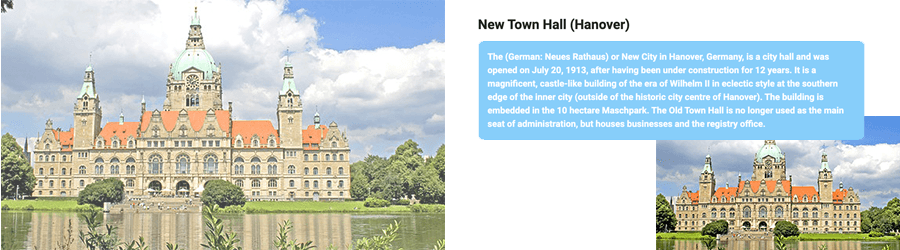

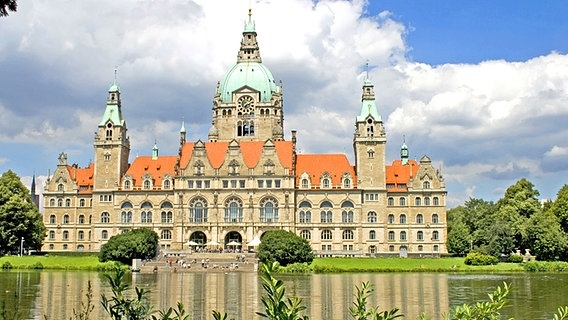

In [ ]:
#@markdown ## Upload Image
#@markdown ### Enter a file path:
#@markdown * Option A: Upload your own file on the left and specify file name.
#@markdown * Option B: Use `use-cases/annotate-landmark-description/assets/landmark_demo.png` for a sample image.
FILE_PATH = 'use-cases/annotate-landmark-description/assets/landmark_demo.png' #@param {type:"string"}
CONFIDENCE_LEVEL = 0.7 #@param {type:"slider", min:0, max:1, step:0.02}

#@markdown ---
#@markdown ### RAPYD.AI Parameters
#@markdown Enter your RAPYD.AI Account ID and Token (You can find both in your [dashboard](https://www.rapyd.ai/app/start). If you don't use RAPYD.AI yet, [sign up here](https://www.rapyd.ai/app/sign-up) free of charge.)

#@title RAPYD.AI API Settings
ACCOUNTID = 'your-accountid' #@param {type:"string"}
TOKEN = 'your-token' #@param {type:"string"}
PROVIDER = 'gcp' #@param ["gcp"]

!git clone https://github.com/rapyd-ai/use-cases.git 2> /dev/null 
!pip -q install wikipedia

# 0. Imports ----
import wikipedia
import cv2
import json
import requests
from IPython.display import display, HTML, Image

# 1. Custom Functions ----
def scale_image(img, max_width=640, max_height=480):
  # Scales an cv2 image down if it is larger than the sepecified dimensions.
  img_width = img.shape[1]
  img_height = img.shape[0]

  if img_width >= img_height:
    if img_width > max_width:
      scale_target = max_width  
      width = scale_target
      height = int(img_height * scale_target / img_width)
      dim = (width, height)
      # resize image
      img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

  if img_width < img_height:
    if img_height > max_height:
      scale_target = max_height  
      height = scale_target
      width = int(img_width * scale_target / img_height)
      dim = (width, height)
      # resize image
      img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
  return(img)

# 2. Data Preprocessing ----
img = scale_image(cv2.imread(FILE_PATH, cv2.IMREAD_UNCHANGED)) # Downscale image
img_width = img.shape[1]
img_height = img.shape[0]
cv2.imwrite("original-resized.jpg", img) # This will be sent to the API

# 3. RAPYD.AI API Call ----
url = "https://api.rapyd.ai/v1/vision/landmark"

payload = {}
files = [
  ('file', open('original-resized.jpg','rb'))
]
headers = {
  'PROVIDER': PROVIDER,
  'ACCOUNT-ID': ACCOUNTID,
  'Authorization': 'Bearer ' + TOKEN
}

response = requests.request("POST", url, headers=headers, data = payload, files = files)

try:
  result = json.loads(response.text.encode('utf8'))['result']

except:
  print(json.loads(response.text.encode('utf8')))

# 4. Get description from Wikipedia

try:
  # Filter response by minimum score
  landmarks = [d for d in result if d['score'] > CONFIDENCE_LEVEL]

  # Get Geocoordinates for first item
  LAT = landmarks[0]['locations'][0]['lat']
  LONG = landmarks[0]['locations'][0]['lng']

  # Search for attraction on Wikipedia by geo coordniates
  WIKIPEDIA_TITLE = wikipedia.geosearch(LAT, LONG, radius = 500)[0]

  # Get summary
  description = wikipedia.summary(WIKIPEDIA_TITLE)

except:
  WIKIPEDIA_TITLE = "No Landmark Detected"
  description = "Please try another image or decrease the confidence level."

# 5. Format output

display(HTML("<h2>" + WIKIPEDIA_TITLE +"</h2>"),
        HTML("<div style='width: 576px; padding:12px; margin-top: 12px; margin-bottom: 24px; line-height: 1.5em; border:3px solid lightskyblue; border-radius: 8px; background-color: lightskyblue; color: white; font-weight: bold;'>" + description +"</div"), 
        Image("original-resized.jpg", width = 600))

## What's next?

Experiment with different inputs and parameters.

If you want to customize this Use Case even further, simply double click on the form and you will see the source code of this application.

Copy, edit and share as you like.